# Introduction

In this notebook, we develop and test the BabyNet architecture.

The other notebooks, as well as the thesis can be found at https://github.com/fridowicke/infant_cries

# Imports

In [ ]:
import tensorflow as tf
import numpy as np
from google.colab import drive
import json

from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

# Loading the Data

## Mount the Drive

In [ ]:
drive.mount('/content/drive')

## Save / Load Processed Data

In [ ]:
#We use json to save the spectrograms and f0s of the produced data in order to avoid computing them every time we use the notebook.
#Helper functions
def save(data, filename):
    if type(data) is np.ndarray:
      data = data.tolist()
    with open(filename, 'w') as f:
        json.dump(data, f, ensure_ascii=False)
        
def load(filename):
    with open(filename) as data:
        x = json.load(data)
    return np.array(x)

In [ ]:
#Load the Data
specs_train = load("/content/drive/My Drive/infant_cries/data_js_final/specs_train.json")
y_train = load("/content/drive/My Drive/infant_cries/data_js_final/y_train.json")
specs_dev_ger = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_ger.json")
specs_dev_jap = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_jap.json")
specs_test_ger = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_ger.json")
specs_test_jap = load("/content/drive/My Drive/infant_cries/data_js_final/specs_dev_jap.json")
specs_eval = load("/content/drive/My Drive/infant_cries/data_js_final/specs_eval.json")
X_dev_ger = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_ger.json")
X_dev_jap = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_jap.json")
X_test_ger = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_ger.json")
X_test_jap = load("/content/drive/My Drive/infant_cries/data_js_final/X_dev_jap.json")
X_eval = load("/content/drive/My Drive/infant_cries/data_js_final/X_eval.json")


## Create Datasets

In [ ]:
#Size of the Dataset
n, height, width = specs_train.shape
n_dev_ger = specs_dev_ger.shape[0]
n_dev_jap = specs_dev_jap.shape[0]
n_test_ger = specs_test_ger.shape[0]
n_test_jap = specs_test_jap.shape[0]
n_eval = specs_eval.shape[0]

#Create the ys for dev and test set
y_dev_ger = np.zeros(n_dev_ger)
y_dev_jap = np.ones(n_dev_jap)
y_test_ger = np.zeros(n_test_ger)
y_test_jap = np.ones(n_test_jap)

#Reshape spectrograms for train, dev, test, eval
specs_train = specs_train.reshape([n,height,width,1])
specs_dev_ger = specs_dev_ger.reshape([n_dev_ger,height,width,1])
specs_dev_jap = specs_dev_jap.reshape([n_dev_jap,height,width,1])
specs_test_ger = specs_test_ger.reshape([n_test_ger,height,width,1])
specs_test_jap = specs_test_jap.reshape([n_test_jap,height,width,1])
specs_eval = specs_eval.reshape([n_eval,height,width,1])

#Create mixed dev set
specs_dev = np.zeros((2*n_dev_jap, height, width, 1))
specs_dev[:n_dev_jap] = specs_dev_jap
specs_dev[n_dev_jap:] = np.vstack((specs_dev_ger,specs_dev_ger,specs_dev_ger,specs_dev_ger))[:n_dev_jap]
y_dev = np.zeros(2*n_dev_jap)
y_dev[:n_dev_jap] = 1

#Create mixed test set
specs_test = np.zeros((2*n_test_jap, height, width, 1))
specs_test[:n_test_jap] = specs_test_jap
specs_test[n_test_jap:] = np.vstack((specs_test_ger,specs_test_ger,specs_test_ger,specs_test_ger))[:n_test_jap]
y_test = np.zeros(2*n_test_jap)
y_test[:n_test_jap] = 1

#Create the eval set
y_eval = np.zeros(n_eval)

#Set the Class Names
class_names = ["German", "Japanese"]

# Function to build BabyNet

In [ ]:
def build_cnn(optimizer, conv_layer_size, conv_layer_num, dense_layer_num, do=0):  # random search passes this hyperparameter() object 
    cnn = keras.models.Sequential()
    cnn.add(layers.Rescaling(1./np.max(specs_train), input_shape=(height, width,1)),)

    dense_layer_num 

    for idx in range(conv_layer_num):
      cnn.add(layers.Conv2D(conv_layer_size*2**idx, 3, padding = 'same', input_shape=(height, width,1)))
      cnn.add(layers.BatchNormalization())
      cnn.add(layers.MaxPooling2D((2,2), padding='same'))

    cnn.add(layers.Flatten()) 

    for idx in range(dense_layer_num):
      cnn.add(layers.Dense(conv_layer_size*2**(conv_layer_num-idx), activation='relu'))
      cnn.add(layers.BatchNormalization())
      if do:
        cnn.add(layers.Dropout(0.5))

    cnn.add(layers.Dense(2))

    cnn.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return cnn



In [ ]:
cnn = build_cnn('Adam', 8, 6, 2, do=0.3)
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 89, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 120, 89, 8)        80        
                                                                 
 batch_normalization (BatchN  (None, 120, 89, 8)       32        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 45, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 45, 16)        1168      
                                                                 
 batch_normalization_1 (Batc  (None, 60, 45, 16)      

# Hyperparameter Sweep for CNN using WandB

In [ ]:
#Imports

!pip install wandb
import wandb
wandb.login()
#wandb.login(key="eee00ac31672101f71ba23849e856a841e57361f")

## Setting up the Sweep config

In [ ]:
sweep_config_final = {
    'method' : 'grid',
    'metric' : {'name': 'accuracy_dev',
                'goal': 'maximize'},
    'parameters': {
        'optimizer': {
            'values': ['adam']
            },
        'conv_layer_size': {
            'values': [4, 8, 16]
            },
        'conv_layer_num': {
            'values': [2, 3, 4, 5, 6]
            },
        'dense_layer_num': {
            'values': [2, 3, 4, 5, 6]
            },
        'epochs': {
            'values': [10 ,14, 22, 26, 30, 40]
            },
        'dropout': {
            'values': [0.3, 0.4,  0.5, 0.6, 0.7]
        }
    },
     
}

In [ ]:
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        accs_dev_ger = []
        accs_dev_jap = []
        accs_dev = []
        accs_test_ger = []
        accs_test_jap = []
        accs_test = []
        accs_eval = []
        for idx in range(5):
          cnn = build_cnn(config.optimizer, config.conv_layer_size, config.conv_layer_num, config.dense_layer_num, do=config.dropout)
          cnn.fit(specs_train, y_train, epochs = config.epochs)
          _, acc_dev_ger = cnn.evaluate(specs_dev_ger, y_dev_ger)
          _, acc_dev_jap = cnn.evaluate(specs_dev_jap, y_dev_jap)
          _, acc_test_ger = cnn.evaluate(specs_test_ger, y_test_ger)
          _, acc_test_jap = cnn.evaluate(specs_test_jap, y_test_jap)
          _, acc_eval = cnn.evaluate(specs_eval, np.zeros(n_eval))
          accs_dev_ger.append(acc_dev_ger)
          accs_dev_jap.append(acc_dev_jap)
          accs_dev.append((acc_dev_ger+acc_dev_jap)/2)
          accs_test_ger.append(acc_test_ger)
          accs_test_jap.append(acc_test_jap)
          accs_test.append((acc_test_ger+acc_test_jap)/2)
          
        acc_dev_ger = np.mean(accs_dev_ger)
        acc_dev_jap = np.mean(accs_dev_jap)
        acc_dev = np.mean(accs_dev)
        acc_test_ger = np.mean(accs_test_ger)
        acc_test_jap = np.mean(accs_test_jap)
        acc_test = np.mean(accs_test)

        wandb.log({'accuracy_dev_ger': acc_dev_ger, 'accuracy_dev_jap': acc_dev_jap, 'accuracy_dev': acc_dev, "accuracy_eval": acc_eval})
          
     

## Executing the Sweep

In [ ]:
#sweep_id_final = wandb.sweep(sweep_config_final, project="BabyNet_Hyperparameter_Tuning")

In [ ]:
#wandb.agent(sweep_id_final, train)

In [ ]:
wandb.agent("3h4fy27w", project="BabyNet_Hyperparameter_Tuning", function=train)

# Testing the Network with optimal Parameters

### Finding the optimal Parameters from WandB preselection

In [ ]:
#UPDATE W. TEST
best_params = [[8,6,2,0.3,30],
              [16,6,3,0.5,22],
              [8,6,2,0.3,40],
              [8,6,4,0.3,22],
              [8,6,2,0.3,22],
              [8,5,3,0.6,22],
              [16,6,2,0.3,40],
              [16,5,4,0.4,30],
              [8,5,5,0.6,40],
              [8,6,2,0.5,26]]


accs_dev, accs_test, accs_eval = [], [], []
for idx1, params in enumerate(best_params):

  accs_dev_idx, accs_test_idx, accs_eval_idx = [], [], []
  for idx in range(100):
    conv_layer_size, conv_layer_num, dense_layer_num, do, epochs = params
    cnn = build_cnn('Adam',conv_layer_size, conv_layer_num, dense_layer_num, do)
    cnn.fit(specs_train, y_train, epochs = epochs, verbose=0)
    _, acc_dev = cnn.evaluate(specs_dev, y_dev, verbose=0)
    _, acc_test = cnn.evaluate(specs_test, y_test, verbose=0)
    _, acc_eval = cnn.evaluate(specs_eval, np.zeros(n_eval), verbose=0)
    accs_dev_idx.append(acc_dev)
    accs_test_idx.append(acc_test)
    accs_eval_idx.append(acc_eval)
    if idx%10==0:
      print(idx1, idx)
      print(np.mean(accs_dev_idx),np.mean(accs_test_idx),np.mean(accs_eval_idx))
  accs_dev.append(np.mean(accs_dev_idx))
  accs_test.append(np.mean(accs_test_idx))
  accs_eval.append(np.mean(accs_eval_idx))

In [ ]:
save(accs_dev,"/content/drive/My Drive/infant_cries/data_js_final/accs_dev.json")
save(accs_test,"/content/drive/My Drive/infant_cries/data_js_final/accs_test.json")
save(accs_eval,"/content/drive/My Drive/infant_cries/data_js_final/accs_eval.json")

## Experiments with the optimal set of parameters

In [ ]:
accs_dev  = load("/content/drive/My Drive/infant_cries/data_js_final/accs_dev.json")
accs_test = load("/content/drive/My Drive/infant_cries/data_js_final/accs_test.json")
accs_eval = load("/content/drive/My Drive/infant_cries/data_js_final/accs_eval.json")

In [ ]:
best_params = [[8,6,2,0.3,30],
              [16,6,3,0.5,22],
              [8,6,2,0.3,40],
              [8,6,4,0.3,22],
              [8,6,2,0.3,22],
              [8,5,3,0.6,22],
              [16,6,2,0.3,40],
              [16,5,4,0.4,30],
              [8,5,5,0.6,40],
              [8,6,2,0.5,26]]

opt_params = np.argmax(accs_dev)
print("The optimal parameters are",best_params[opt_params])
acc_dev  = np.round(accs_dev[opt_params],2)
acc_test = np.round(accs_test[opt_params],2)
acc_eval = np.round(accs_eval[opt_params],2)
print(f"The accuracies on Dev, Test, Eval are {acc_dev}/{acc_test}/{acc_eval}")

The optimal parameters are [8, 6, 2, 0.3, 40]
The accuracies on Dev, Test, Eval are 0.83/0.83/0.65


In [ ]:
accs_dev_opt  = []
accs_test_opt = []
accs_eval_opt = []
for idx in range(100):
  cnn = build_cnn('Adam', 8, 6, 2, do=0.3)
  cnn.fit(specs_train, y_train, epochs = 40, verbose=0)
  _, acc_dev  = cnn.evaluate(specs_dev, y_dev, verbose=0)
  _, acc_test = cnn.evaluate(specs_test, y_test, verbose=0)
  _, acc_eval = cnn.evaluate(specs_eval, y_eval, verbose=0)
  accs_dev_opt.append(acc_dev)
  accs_eval_opt.append(acc_eval)
  accs_test_opt.append(acc_test)
  if idx%10==0:
    print(idx, np.mean(accs_dev_opt), np.mean(accs_test_opt), np.mean(accs_eval_opt))

save(accs_dev_opt,"/content/drive/My Drive/infant_cries/data_js_final/accs_dev_opt.json")
save(accs_test_opt,"/content/drive/My Drive/infant_cries/data_js_final/accs_test_opt.json")
save(accs_eval_opt,"/content/drive/My Drive/infant_cries/data_js_final/accs_eval_opt.json")

0 0.8956043720245361 0.8956043720245361 0.6601941585540771
10 0.8331668214364485 0.8331668214364485 0.6443071473728527
20 0.8294086768513634 0.8294086768513634 0.6430883010228475
30 0.8195675207722571 0.8195675207722571 0.6047604132083154
40 0.812382731495834 0.812382731495834 0.6448022730466796
50 0.8069381538559409 0.8069381538559409 0.6362078803427079
60 0.8103044443443174 0.8103044443443174 0.6363202274822798
70 0.8174431130919658 0.8174431130919658 0.6358539575422314
80 0.8170533099292238 0.8170533099292238 0.6338247616349915
90 0.8159038699590243 0.8159038699590243 0.6325616122602107


Mean:0.8129120814800262, Min:0.5714285969734192, Max:0.9175823926925659
50th percentile. 0.8351648449897766


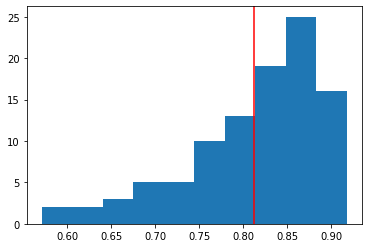

In [ ]:
print(f"Mean:{np.mean(accs_dev_opt)}, Min:{np.min(accs_dev_opt)}, Max:{np.max(accs_dev_opt)}")
print(f"50th percentile. {np.percentile(accs_dev_opt, 50)}")
plt.hist(accs_dev_opt)
plt.axvline(np.mean(accs_dev_opt), color='red')
plt.show()

Mean:0.8129120814800262, Min:0.5714285969734192, Max:0.8279120814800263


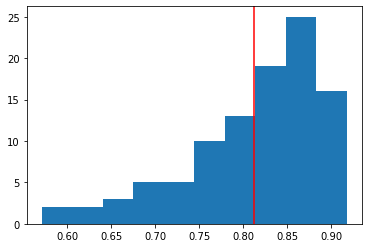

In [ ]:
print(f"Mean:{np.mean(accs_test_opt)}, Min:{np.min(accs_test_opt)}, Max:{np.max(accs_test)}")
plt.hist(accs_test_opt)
plt.axvline(np.mean(accs_test_opt), color='red')
plt.show()

Mean:0.6312621361017228, Min:0.223300963640213, Max:0.9805825352668762


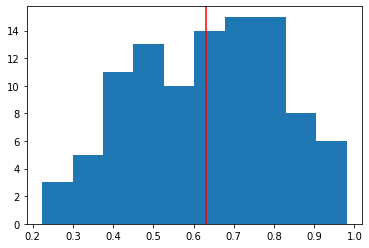

In [ ]:
print(f"Mean:{np.mean(accs_eval_opt)}, Min:{np.min(accs_eval_opt)}, Max:{np.max(accs_eval_opt)}")
plt.hist(accs_eval_opt)
plt.axvline(np.mean(accs_eval_opt), color='red')
plt.show()

# XAI

## Defining functions for XAI

In [ ]:
! pip install shap
import shap
from  matplotlib.colors import LinearSegmentedColormap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 14.6 MB/s 


In [ ]:
n_XAI = 3
inputs = [specs_dev_ger[:n_XAI], specs_dev_jap[:n_XAI], specs_test_ger[:n_XAI], specs_test_jap[:n_XAI], specs_eval[:n_XAI]]
X_in   = [X_dev_ger[:n_XAI], X_dev_jap[:n_XAI], X_test_ger[:n_XAI], X_test_jap[:n_XAI], X_eval[:n_XAI]]
Descriptions = ["Development Set - German samples", "Development Set - Japanese samples",
                "Test Set - German samples", "Test Set - Japanese samples",
                "Evaluation Set - German samples"]

In [ ]:
def shapley(func, input, evals = 10000, mask = "blur(128,128)", num=5):

  # define a masker that is used to mask out partitions of the input image.
  masker_blur = shap.maskers.Image(mask, specs_train[0].shape)

  # create an explainer with model and image masker
  explainer_blur = shap.Explainer(f, masker_blur, output_names=class_names)

  # here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
  return explainer_blur(input, max_evals=evals, batch_size=1, outputs=shap.Explanation.argsort.flip[:2])

##Create the BabyNet for XAI

In [ ]:
acc_dev = 0
while acc_dev<0.835:
  print("x")
  cnn = build_cnn('Adam', 8, 6, 2, do=0.3)
  cnn.fit(specs_train, y_train, epochs = 40, verbose=0)
  _, acc_dev  = cnn.evaluate(specs_dev, y_dev, verbose=0)
  _, acc_test = cnn.evaluate(specs_test, y_test, verbose=0)
  _, acc_eval = cnn.evaluate(specs_eval, y_eval, verbose=0)

print(f"Accuracies Dev/Test/Eval: {acc_dev}/{acc_test}/{acc_eval}")

x
Accuracies Dev/Test/Eval: 0.8956043720245361/0.8956043720245361/0.737864077091217


## XAI for BabyNet

In [ ]:
def f(x):
    ret = cnn.predict(x)
    return ret

In [ ]:
inputs[0].shape

(3, 120, 89, 1)

  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 3/3 [07:21<00:00, 111.19s/it]

  0%|          | 0/9998 [00:00<?, ?it/s]

Partition explainer: 4it [11:03, 221.03s/it]


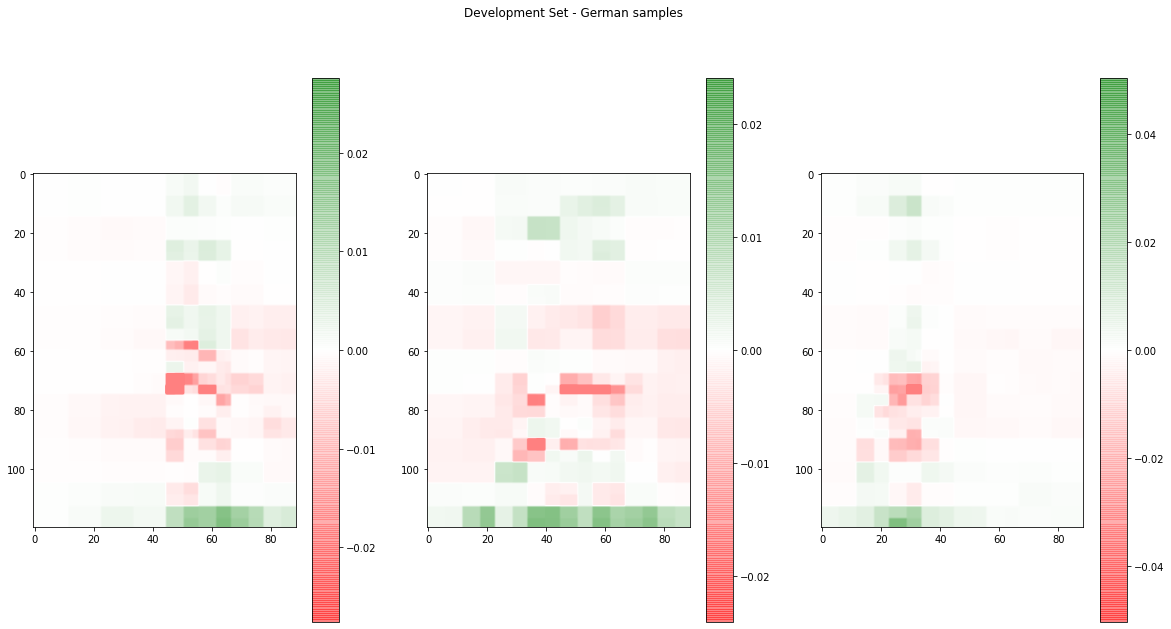

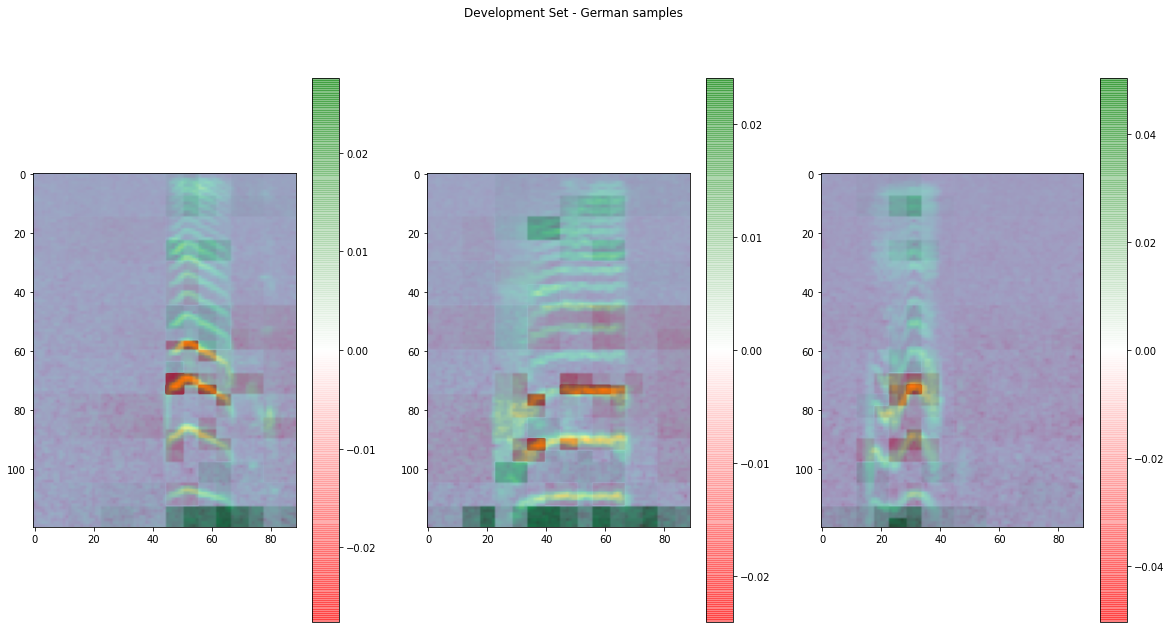

NameError: ignored

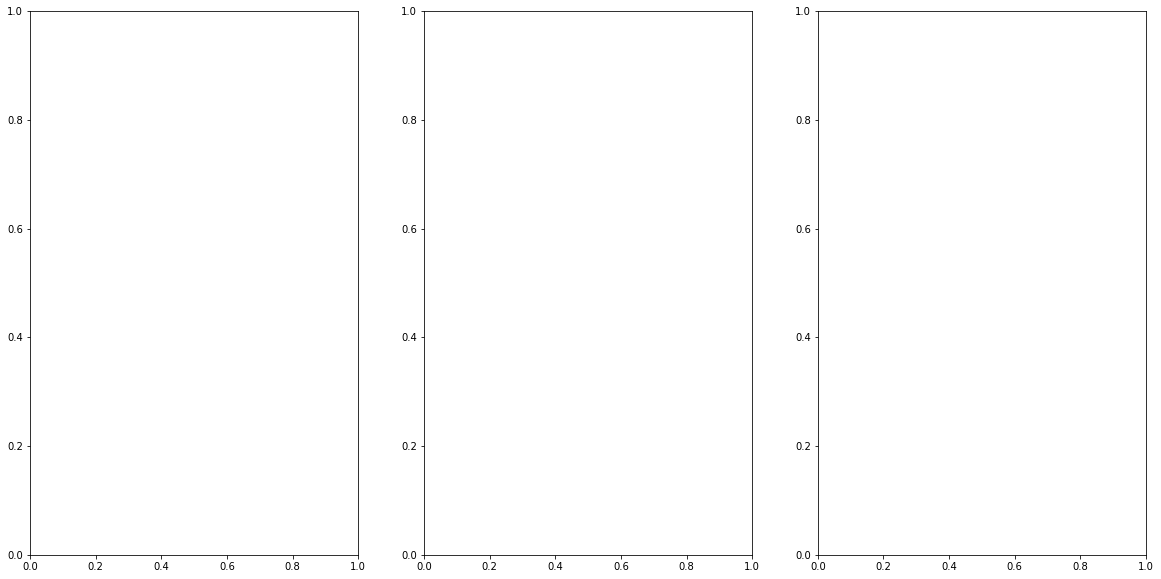

In [ ]:
for idx in range(5):
  specs, Xs, text = inputs[idx], X_in[idx], Descriptions[idx]
  shap_map = shapley(f, specs, evals = 10000)
  
  fig, ax = plt.subplots(1,n_XAI, figsize = (20,10))
  for idx2 in range(n_XAI):
    im = shap_map[idx2].values[:,:,0,0]
    mx = np.max(im)
    a = ax[idx2]
    c = a.imshow(im, alpha=0.5, cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256), vmin = -mx, vmax = mx)
    fig.colorbar(c, ax=a)
  fig.suptitle(text)
  plt.show()
  fig.savefig("Colormap"+text+".png")

  fig, ax = plt.subplots(1,n_XAI, figsize = (20,10))
  for idx2 in range(n_XAI):
    im = shap_map[idx2].values[:,:,0,0]
    mx = np.max(im)
    a = ax[idx2]
    p = a.imshow(-1*specs[idx2,:,:,0])
    c = a.imshow(im, alpha=0.5, cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256), vmin = -mx, vmax = mx)
    fig.colorbar(c, ax=a)
  fig.suptitle(text)
  plt.show()
  fig.savefig("Colormapandspec"+text+".png")

  fig, ax = plt.subplots(1,n_XAI, figsize = (20,10))
  for idx2 in range(n_XAI):
    im = shap_map[idx2].values[:,:,0,0]
    mx = np.max(im)
    a = ax[idx2]
    p = a.plot(np.arange(X[idx2].shape[0]), X[idx2])
    fig.colorbar(c, ax=a)
  fig.suptitle(text)
  plt.show()
  fig.savefig("wav"+text+".png")

